## Lecture: Music Information Retrieval

Christof Weiß, Computational Humanities group, JMU

# Exercise 4 - Harmony Analysis 

Material by Meinard Müller and Christof Weiß

In this exercise, we apply basic processing steps for harmony analysis of audio recordings. The application is based on chroma features and uses templates for modelling chords and scales. The following FMP notebooks provide useful code snippets and can be helpful:
* [Template-Based Chord Recognition](../C5/C5S2_ChordRec_Templates.ipynb)
* [Chord Recognition Evaluation](../C5/C5S2_ChordRec_Eval.ipynb)
* [HMM-Based Chord Recognition](../C5/C5S3_ChordRec_HMM.ipynb)

## 0. Preparation

Please download the file `Exercise_04_data.zip` from WueCampus (under `Exercise material`), unzip its content and save it to the subfolder named __"data"__ within your notebook directory.

## 1. Generation of chord templates

In this first part, we precompute a set $\mathcal{T}\subset\mathcal{F}=\mathbb{R}^{12}$ of templates denoted by $\mathbf{t}_\lambda\in\mathcal{T}$, $\lambda\in\Lambda$.
Intuitively, each template can be thought of as a prototypical chroma 
vector that represents a specific musical chord.
Furthermore, we fix a similarity measure 

\begin{equation}
s:\mathcal{F}\times\mathcal{F}\to \mathbb{R}
\end{equation}

that allows for comparing different chroma vectors. Then, the template-based procedure consists in assigning the chord label that maximizes the similarity between the corresponding template and the given feature vector $x_n$:

\begin{equation}
        \lambda_{n} := \underset{\lambda \in \Lambda}{\mathrm{argmax}}
         \,\, s( \mathbf{t}_\lambda , x_n ).
\end{equation}

In this procedure, there are many design choices that crucially influence the performance of a chord recognizer. Which chords should be considered in $\mathcal{T}$? How are the chord templates defined?  What is a suitable similarity measure to compare the feature vectors with the chord templates? 

To obtain a first simple chord recognition system, we make the following design choices. For the chord label set $\Lambda$, we choose the twelve major and minor triads. This choice, even though problematic from a musical point of view, is convenient and instructive. Considering chords up to enharmonic equivalence and up to octave shifts, each triad can be encoded by a three-element subset of $[0:11]$. For example, the $\mathrm{C}$ major chord $\mathbf{C}$ corresponds tto the subset $\{0,4,7\}$. Each subset, in turn, can be identified with a binary twelve-dimensional chroma vector $x=(x(0),x(1),\ldots,x(11))^\top$, where $x(i)=1$ if and only if the chroma value $i\in[0:11]$ is contained in the chord. For example, in the case of the $\mathrm{C}$ major chord $\mathbf{C}$, the resulting chroma vector is

\begin{equation}
%\label{eq:ChordReco:Template:Basic:ChromaVectC}
    \mathbf{t}_{\mathbf{C}}{} := x =(1,0,0,0,1,0,0,1,0,0,0,0)^\top
\end{equation}

Using a chroma-based encoding, the twelve major chords and twelve minor chords can be obtained by cyclically shifting the binary vectors for the $\mathrm{C}$ major and the $\mathrm{C}$ minor triads, respectively.

### 1.1. Major and minor triads

In the following, the binary template for the C major triad is given. Please add the corresponding template for the __C minor triad__. Then, complement the function `generate_template_matrix` to automatically generate __all transpositions__ for each of the C-based templates using the function `np.roll` for cyclically shifting the entries of a vector. Then, __plot the resulting template matrix__ and add suitable ticks, tick labels, and axis labels to the plot (make use of the predefined `chroma_labels`).

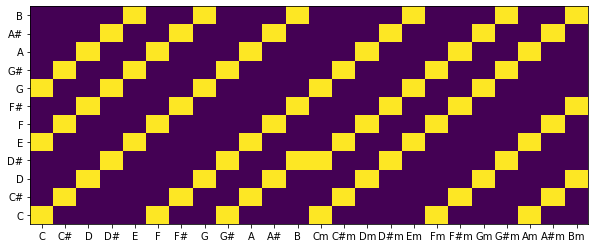

In [208]:
import os
import numpy as np
from matplotlib import pyplot as plt
import librosa
import IPython.display as ipd
%matplotlib inline

def generate_template_matrix(templates):
    
    assert templates.shape[0] == 12, 'input "templatesC" has wrong size!'
    
    template_matrix = np.zeros((12, 12 * templates.shape[1]))

    for shift in range(12):
        template_matrix[:,shift] = np.roll(templates[:,0],shift)
        if templates.shape[1] > 1:
            template_matrix[:,shift+12]=np.roll(templates[:,1],shift)

    return template_matrix


template_cmaj = np.array([[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]]).T
template_cmin = np.array([[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]]).T

templates_majmin = generate_template_matrix(np.concatenate((template_cmaj, template_cmin), axis=1))

fig = plt.figure(figsize=(10, 4))
chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
chord_label_maj = chroma_label
chord_label_min = [s + 'm' for s in chroma_label]
chord_labels = chord_label_maj + chord_label_min

## your code here (plot the matrix)
plt.imshow(templates_majmin, origin='lower', aspect='auto',cmap="viridis")
plt.xticks(np.arange(len(chord_labels)), chord_labels)
plt.yticks(np.arange(len(chroma_label)),chroma_label)
plt.show()

### 1.2 Diminished and augmented triads

Now, repeat the template generation and visualization by adding also the __diminished__ and __augmented triads__, using the function `generate_template_matrix` implemented above. What can you observe in the case of the augmented triads?

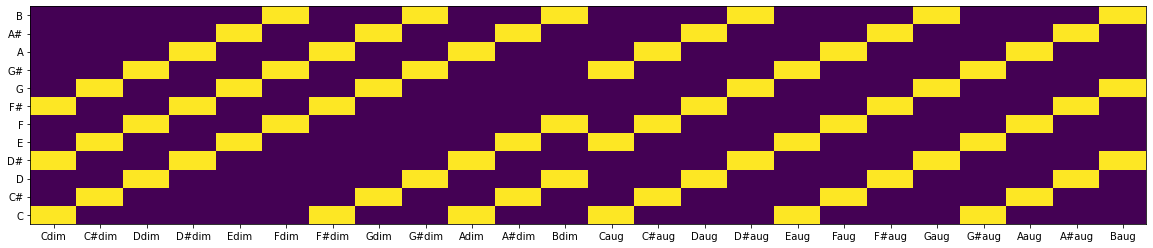

In [209]:
## your code here
template_cdim = np.array([[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]]).T
template_caug = np.array([[1, 0, 0, 0, 1, 0, 0, 0, 1 ,0 ,0, 0]]).T

templates_triads = generate_template_matrix(np.concatenate((template_cdim,template_caug),axis=1))


## your code here (plot the matrix)
fig = plt.figure(figsize=(20, 4))
chroma_label = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
chord_label_dim = [s + 'dim' for s in chroma_label]
chord_label_aug = [s+'aug' for s in chroma_label]
chord_labels_ext = chord_label_dim + chord_label_aug

## your code here (plot the matrix)
plt.imshow(templates_triads, origin='lower', aspect='auto',cmap="viridis")
plt.xticks(np.arange(len(chord_labels_ext)), chord_labels_ext)
plt.yticks(np.arange(len(chroma_label)),chroma_label)
plt.show()

## 2. Template-based chord recognition

We now want to apply our major and minor chord templates for chord recognition. As running example, we use in this notebook the chorale "Durch Dein Gefängnis" by Johann Sebastian Bach (1685-1750), No. 22 from _St. John Passion_ BWV 245. Here, you can see a condensed score (_piano reduction_ or _vocal score_ ) of the piece:

<img src="../data/C5/FMP_C5_Audio_Bach_BWV245-No22_Score-Sibelius.png" width="1200px" align="middle" alt="FMP_C5_F13">

<audio style="width: 400px;" src="data/Bach_BWV245-No22_VokalensembleIlmenau.wav" type="audio/mpeg" controls="controls"></audio>

### 2.1 Computation and visualization of chroma features

First, we compute chroma features of the chorale recording. For this, we use a built-in function of the library `librosa`, which is based on a filter bank. Please execute the chroma feature extraction. Note that the performance is in historical tuning (concert pitch 415 Hz) and correct the chromagram accordingly. Then, plot the resulting chromagram as a grayscale matrix using the function `LibFMP.B.plot_matrix`.

(<Figure size 432x216 with 2 Axes>,
 [<AxesSubplot:xlabel='Time (seconds)', ylabel='Chroma (Standard Tuning)'>],
 <matplotlib.image.AxesImage at 0x1f986813048>)

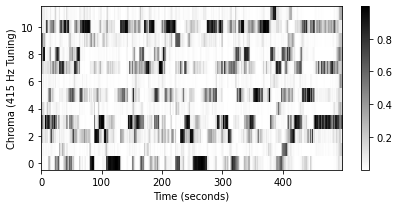

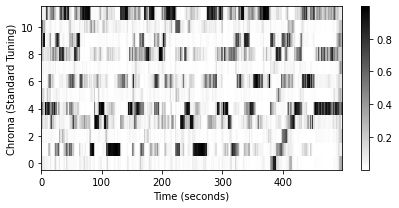

In [210]:
import sys
sys.path.append('..')

import matplotlib.gridspec as gridspec
import libfmp.b
import libfmp.c3

# load wav file
fn_wav = os.path.join('data', 'Bach_BWV245-No22_VokalensembleIlmenau.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, sr=Fs)
ipd.Audio(x, rate=Fs)

# estimate tuning
tuning_offset = librosa.estimate_tuning(y=x, sr=Fs, S=None, n_fft=4096, resolution=0.01, bins_per_octave=12)

# set chroma parameters
N = 4096
H = 2205
gamma = 100
norm_p = 2;

# compute chroma features with elliptic filter bank
P = librosa.iirt(y=x, sr=Fs, win_length=N, hop_length=H, center=True, tuning=tuning_offset)
C = librosa.feature.chroma_cqt(C=P, bins_per_octave=12, n_octaves=7, fmin=librosa.midi_to_hz(24), norm=norm_p)


# Account for historical tuning (=transpose semitone up)
C_440 = np.zeros(C.shape)
for c in range(12):
    C_440[c,:] = C[(c-1)%12,:]
# Plot chromagram
libfmp.b.plot_matrix(C,ylabel="Chroma (415 Hz Tuning)")
libfmp.b.plot_matrix(C_440,ylabel="Chroma (Standard Tuning)",)



### 2.2 Template matching

Now, please implement a function for the template matching using the template matrix `templates_majmin` generated above. Note that each chroma vector needs to be compared to each column of the template matrix. Furthermore, normalization with respect to the $\ell_2$-norm must be done before computing the inner product. To this end, you can make use of the function `LibFMP.C3.normalize_feature_sequence`. Plot the resulting time-chord representation.


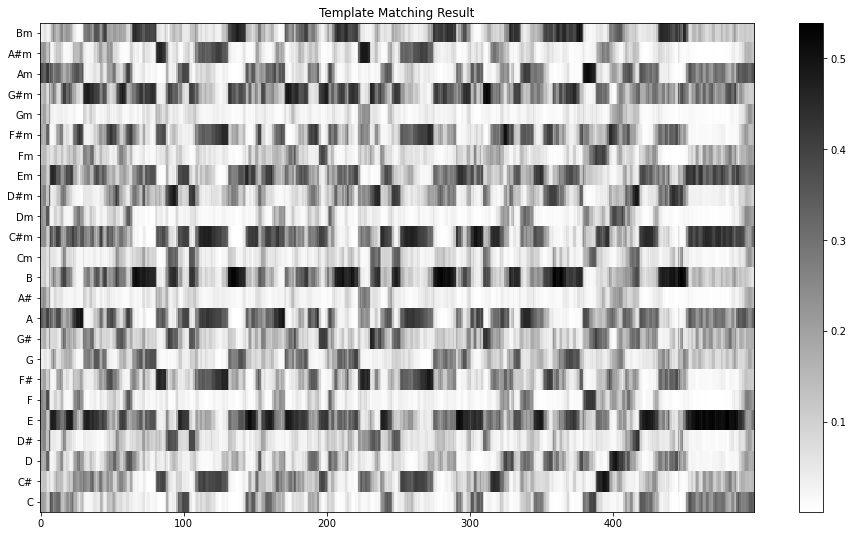

In [211]:
def analysis_template_match(f_chroma, templates, apply_normalization=True, norm_output='2'):
    
    assert f_chroma.shape[0] == 12, 'input "f_chroma" has wrong size!'
    assert templates.shape[0] == 12, 'input "templates" has wrong size!'
    chroma_normalized = libfmp.c3.normalize_feature_sequence(f_chroma, norm='2')
    templates_normalized = libfmp.c3.normalize_feature_sequence(templates, norm='2')
    f_analysis = np.dot(templates_normalized.T,chroma_normalized)
    if apply_normalization:
      f_analysis = libfmp.c3.normalize_feature_sequence(f_analysis,norm=norm_output)
    
    return f_analysis


# Template-based chord recognition
f_analysis = analysis_template_match(C_440, templates_majmin, apply_normalization=True, norm_output='2')

# Generate chord labels
chord_labels = chord_label_maj + chord_label_min


## your code here (plot the resulting time-chord representation f_analysis as grayscale image using imshow)
plt.figure(figsize=(16,9))
plt.imshow(f_analysis, origin='lower', aspect='auto', cmap="gray_r", interpolation='none')
plt.title("Template Matching Result")
#plt.xticks(np.arange(len(chord_labels_ext)), chord_labels_ext)
plt.yticks(np.arange(len(chord_labels)),chord_labels)
plt.colorbar()
plt.show()

### 2.3 Label assignment

For completing the chord labelling, we have to decide on a chord label for each frame. Please convert the time-chord representation to a binary matrix by deciding on the most likely chord label (maximal similarity) for each frame, setting all other values to zero.

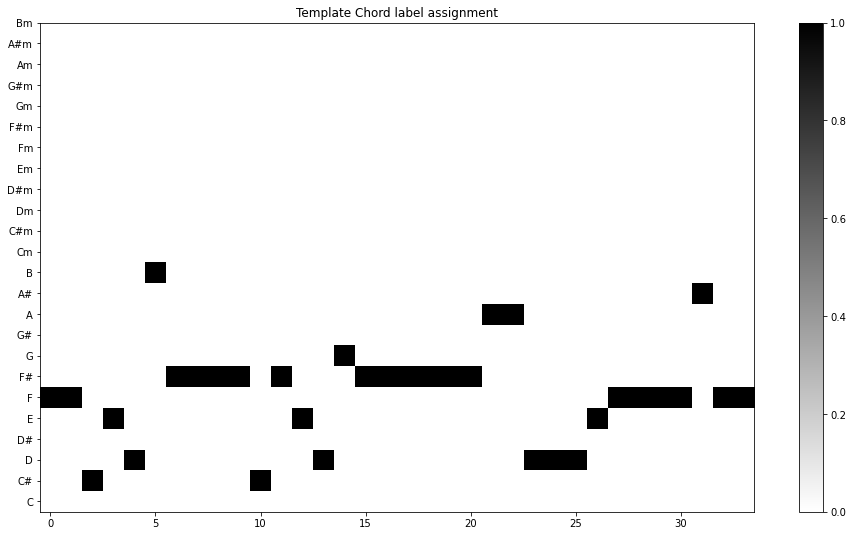

In [217]:
## your code here (compute binary matrix of maximizing entries only)
def assign_labels(f_analysis_input):
    label_assignment = np.zeros(f_analysis_input.shape)
    max_indices = np.argmax(f_analysis_input,0)
    for timeindex,chord in enumerate(max_indices):
        label_assignment[chord,timeindex] = 1
    return label_assignment

label_assignment = assign_labels(f_analysis)
## your code here (plot the binary time-chord representation f_analysis_max)
plt.figure(figsize=(16,9))
plt.imshow(label_assignment, origin='lower', aspect='auto', cmap="gray_r", interpolation = 'none')
#plt.xticks(np.arange(len(chord_labels_ext)), chord_labels_ext)
plt.yticks(np.arange(len(chord_labels)),chord_labels)
plt.colorbar()
plt.title("Template Chord label assignment")
plt.show()

### 2.4 Prefiltering: Temporal smoothing

In the plot above, we observe many chord labels of very short duration. To overcome this problem, we now use a prefiltering procedure, where we apply average filtering of the chromagram prior to the template matching step. Please use the function `LibFMP.C3.smooth_downsampling` from the FMP notebook on [Temporal Smoothing and Downsampling](../C3/C3S1_FeatureSmoothing.ipynb)
Plot the resulting binary matrix. What is a suitable filter length value?

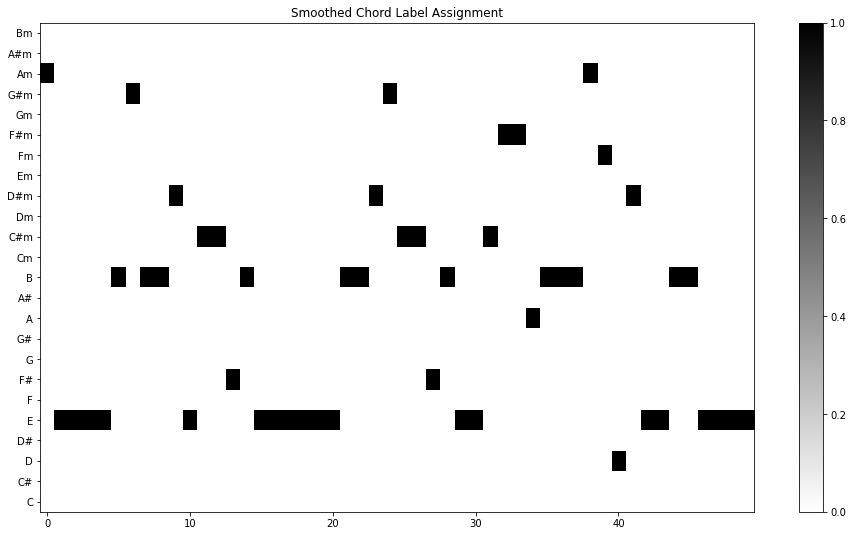

In [218]:
from scipy import signal

# average filtering

filt_len = 15
down_sampling=10

## your code here
C_filtered, Fs_smooth = libfmp.c3.smooth_downsample_feature_sequence(C_440,Fs,filt_len=filt_len,down_sampling=down_sampling)

f_analysis_prefilt = analysis_template_match(C_filtered,templates_majmin,apply_normalization=True,norm_output='2')
f_analysis_max_prefilt = assign_labels(f_analysis_prefilt)
## your code here (plot results)
plt.figure(figsize=(16,9))
plt.imshow(f_analysis_max_prefilt, origin='lower', aspect='auto', cmap="gray_r")
plt.yticks(np.arange(len(chord_labels)),chord_labels)
plt.colorbar()
plt.title("Smoothed Chord Label Assignment")
plt.show()

## 3. Visualization of Diatonic Scales (local keys)

Tonal analysis comprises a number of concepts from music theory, which relate to musical properties on different time scales. For example, the _global key_ refers to the whole piece or movement, whereas _chords_ are local phenomena. The automatic analysis of music recordings regarding these phenomena leads to different task in music information retrieval. In this notebook, we demonstrate how to analyze a music recording with respect to _diatonic scales_ , a concept that closely relates to _local keys_.

<img src="../data/C5/FMP_C5_TonalStructures.png" width="800px" align="middle" alt="FMP_C5_F13">

### 3.1 Re-ordering by perfect fifths

We now implement a method for diatonic scale estimation. To this end, we first perform prefiltering with a high filter length of 45 frames. We now re-order our chromagram to a series of perfect fifths, starting with the pitch class `F`. One can do this efficiently by indexing the pitch classes using the modulo operation (function `np.mod`). Recall that a perfect fifth has a size of 7 semitones and pitch classes are given by indizes in the range $\{0, \ldots 11\}$.

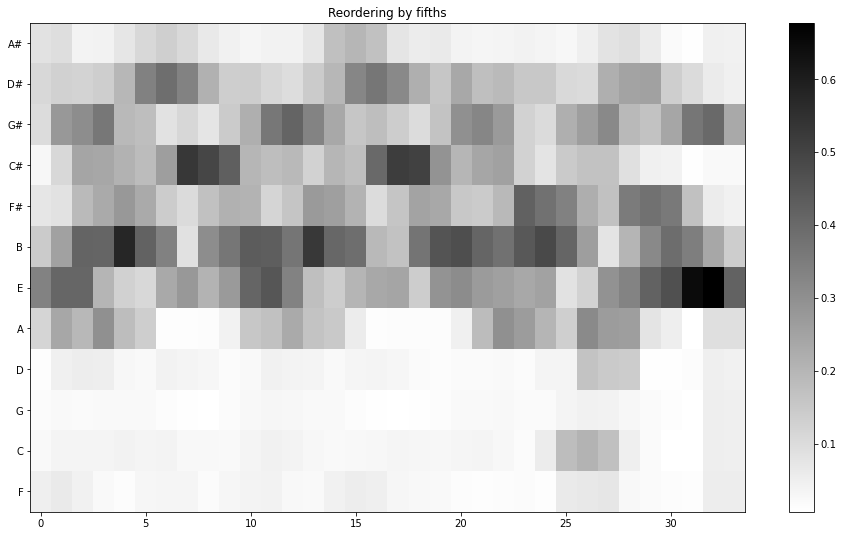

In [214]:
def sort_by_fifths(feature_sequence, offset=0):
    
    ## your code here

    fifth_indices = np.mod([x*7 for x in range(12)],12)
    
    assert(feature_sequence.shape[0]==12), 'input "templatesC" has wrong size!'
    feature_sequence_sorted = np.roll(feature_sequence[fifth_indices,:], shift=-offset, axis=0)
    
    return feature_sequence_sorted


filt_len = 45
down_sampling = 15

## your code here
C_filtered, Fs_smooth = libfmp.c3.smooth_downsample_feature_sequence(C_440,Fs,filt_len=filt_len,down_sampling=down_sampling)

# re-order chroma by perfect fifths
offset = -1  # start with pitch class F
C_sorted = sort_by_fifths(C_filtered, offset=offset)
chroma_label_sorted = ['F', 'C', 'G', 'D', 'A', 'E', 'B', 'F#', 'C#', 'G#', 'D#', 'A#']


# plt.figure(figsize=(10, 14))
# gs = gridspec.GridSpec(3, 2, width_ratios=[1, 0.02])

# ax0 = plt.subplot(gs[0, 0])
# ax1 = plt.subplot(gs[0, 1])
# ax2 = plt.subplot(gs[1, 0])
# ax3 = plt.subplot(gs[1, 1])
# ax4 = plt.subplot(gs[2, 0])
# ax5 = plt.subplot(gs[2, 1])

## your code here (plot chroma features)
plt.figure(figsize=(16,9))
plt.imshow(C_sorted, origin='lower', aspect='auto', cmap="gray_r")
plt.yticks(np.arange(len(chroma_label_sorted)),chroma_label_sorted)
plt.colorbar()
plt.title("Reordering by fifths")
plt.show()

### 3.2 Diatonic Scale Estimation

Now, implement the diatonic scale estimation using the re-ordered chromagrams computed above. For this, please use the functions `generate_template_matrix` and `analysis_template_match` implemented above. Note that the pitch class order is in perfect fifths now. As for the chord recognition, compute and plot the binary matrix of the scale estimation (only plotting the scale with maximal similarity for each frame).

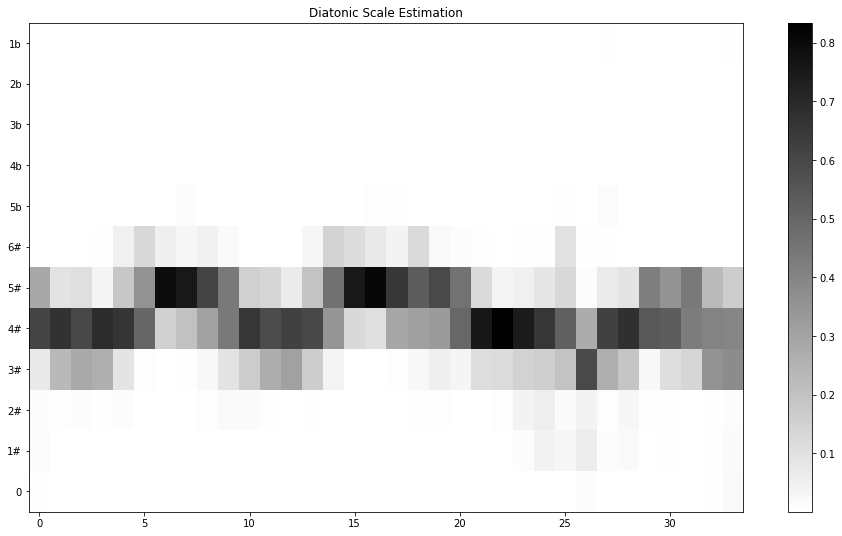

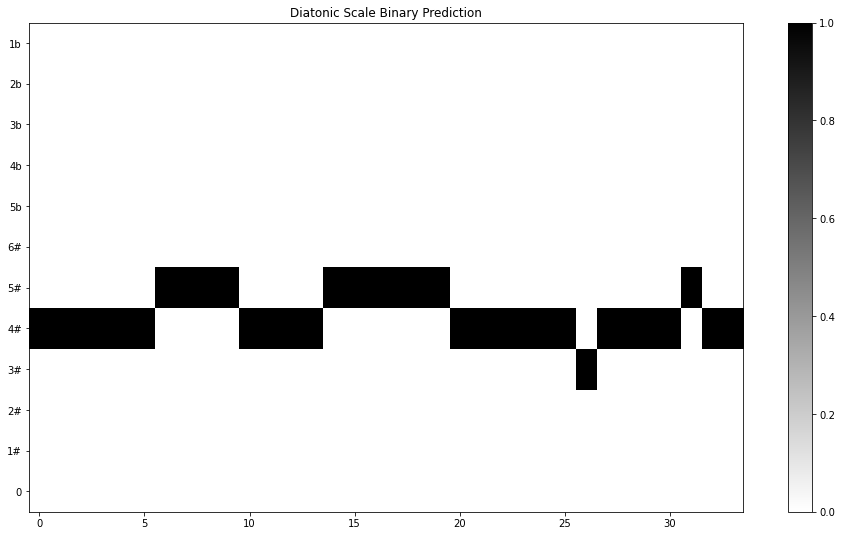

In [221]:
# Scale analysis

template0Diatonic = np.array([[1,1,1,1,1,1,1,0,0,0,0,0]]).T

templates_scale = generate_template_matrix(template0Diatonic)
f_analysis = analysis_template_match(C_sorted,templates_scale,apply_normalization=True,norm_output='2')
f_analysis_norm = f_analysis



# Soft-max rescaling (="opposite" of logarithmic compression)
f_analysis_exp = np.exp(50*f_analysis_norm)
f_analysis_rescaled = f_analysis_exp/f_analysis_exp.sum(axis=0)

scale_labels_absolute = ['0', '1#', '2#', '3#', '4#', '5#', '6#', '5b', '4b', '3b', '2b', '1b']

# plt.figure(figsize=(10, 4))
# gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.02])

# ax0 = plt.subplot(gs[0, 0])
# ax1 = plt.subplot(gs[0, 1])

## your code here (plot result)
plt.figure(figsize=(16,9))
plt.imshow(f_analysis_rescaled, origin='lower', aspect='auto', cmap="gray_r")
plt.yticks(np.arange(len(scale_labels_absolute)),scale_labels_absolute)
plt.colorbar()
plt.title("Diatonic Scale Estimation")
plt.show()

plt.figure(figsize=(16,9))
plt.imshow(assign_labels(f_analysis_rescaled), origin='lower', aspect='auto', cmap="gray_r")
plt.yticks(np.arange(len(scale_labels_absolute)),scale_labels_absolute)
plt.colorbar()
plt.title("Diatonic Scale Binary Prediction")

plt.show()

### 3.3 Diatonic scale estimation with weighted chord notes

Finally, we repeat the following scale analysis using the template given below. This template accounts for the important triads in a diatonic scale (the tonic triads of the corresponding major scale and minor scale, respectively). For the 0 diatonic scale, this weighting emphasizes the pitch classes of the C major chord (C-E-G) and of the A minor chord (A-C-E). How does this affect the visualization as compared to the binary template used before?

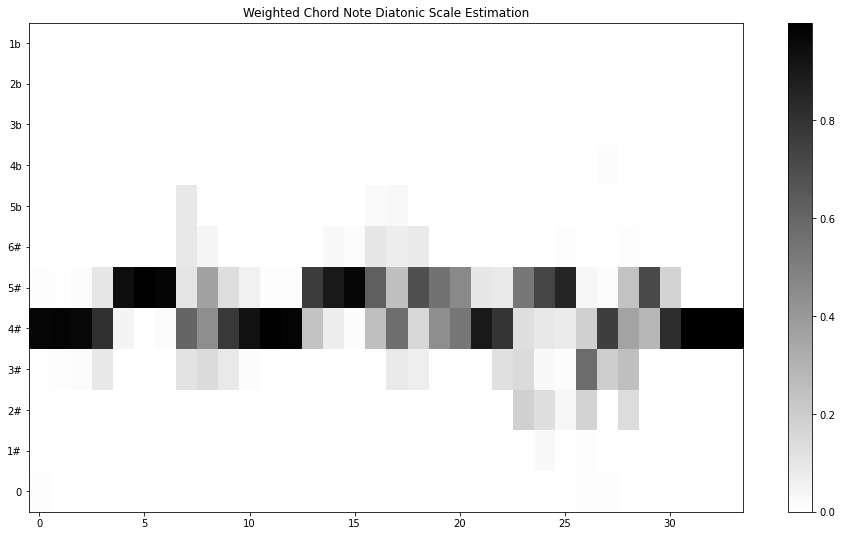

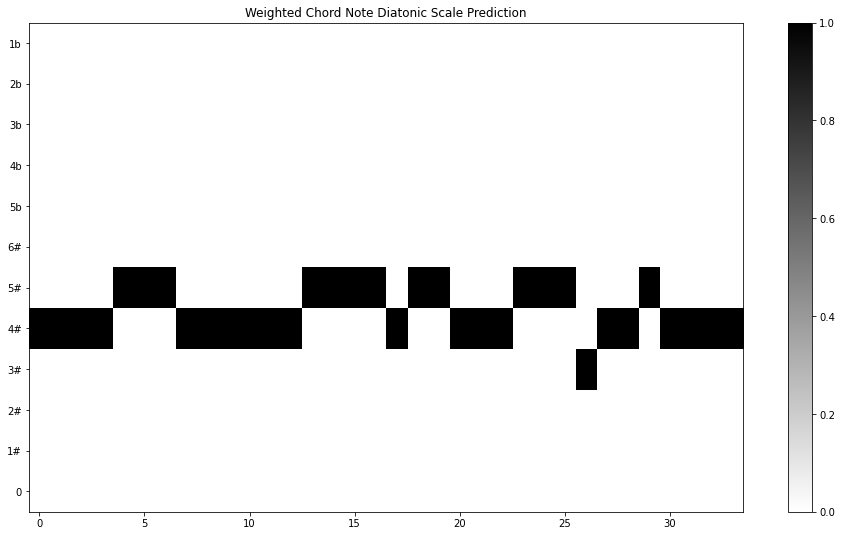

In [223]:
# Scale analysis
template0Diatonic = np.array([[1, 3, 2, 1, 2, 3, 1, 0, 0, 0, 0, 0]]).T

templates_scale = generate_template_matrix(template0Diatonic)
#f_analysis = 
f_analysis_norm = analysis_template_match(C_sorted,templates_scale)


# Soft-max rescaling (="opposite" of logarithmic compression)
f_analysis_exp = np.exp(50*f_analysis_norm)
f_analysis_rescaled = f_analysis_exp/f_analysis_exp.sum(axis=0)

scale_labels_absolute = ['0', '1#', '2#', '3#', '4#', '5#', '6#', '5b', '4b', '3b', '2b', '1b']

# plt.figure(figsize=(10, 4))
# gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.02])

# ax0 = plt.subplot(gs[0, 0])
# ax1 = plt.subplot(gs[0, 1])

## your code here (plot result)
plt.figure(figsize=(16,9))
plt.imshow(f_analysis_rescaled, origin='lower', aspect='auto', cmap="gray_r")
plt.yticks(np.arange(len(scale_labels_absolute)),scale_labels_absolute)
plt.colorbar()
plt.title("Weighted Chord Note Diatonic Scale Estimation")
plt.show()
plt.figure(figsize=(16,9))
plt.imshow(assign_labels(f_analysis_rescaled), origin='lower', aspect='auto', cmap="gray_r")
plt.yticks(np.arange(len(scale_labels_absolute)),scale_labels_absolute)
plt.colorbar()
plt.title("Weighted Chord Note Diatonic Scale Prediction")
plt.show()